In [2]:
!git clone https://github.com/11kartheek/ERA-v2.git

Cloning into 'ERA-v2'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 110 (delta 5), reused 1 (delta 1), pack-reused 103
Receiving objects: 100% (110/110), 211.88 KiB | 26.48 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [12]:
%cd ERA-v2/s10

[Errno 2] No such file or directory: 'ERA-v2/s10'
/kaggle/working/ERA-v2/s10


In [4]:
%ls

README.md  kartheekB_S10.ipynb  models.py  utils.py


In [5]:
!pip install torchsummary

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy
from models import Net
from utils import train_transforms,test_transforms

# Dataset and Creating Train/Test Split

In [16]:
train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [17]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=False) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [18]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.cross_entropy(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [81]:
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.005)
criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import OneCycleLR

LRMIN = 0.002
LRMAX = 0.02
total_epochs = 24
max_at_epoch = 10

# One Cycle Policy scheduler
scheduler = OneCycleLR(optimizer, max_lr=LRMAX, epochs=total_epochs,
                       steps_per_epoch=len(train_loader), pct_start=max_at_epoch/total_epochs, anneal_strategy='linear',
                       div_factor=LRMAX/LRMIN)

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.3938905000686646 Batch_id=97 Accuracy=37.60: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]



Test set: Average loss: 1.3745, Accuracy: 5032/10000 (50.32%)

EPOCH: 1


Loss=1.037942886352539 Batch_id=97 Accuracy=56.86: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s] 



Test set: Average loss: 1.0322, Accuracy: 6327/10000 (63.27%)

EPOCH: 2


Loss=0.7649482488632202 Batch_id=97 Accuracy=68.48: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.8003, Accuracy: 7229/10000 (72.29%)

EPOCH: 3


Loss=0.6761109232902527 Batch_id=97 Accuracy=75.11: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 0.6622, Accuracy: 7682/10000 (76.82%)

EPOCH: 4


Loss=0.6557320356369019 Batch_id=97 Accuracy=79.30: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 0.5982, Accuracy: 7930/10000 (79.30%)

EPOCH: 5


Loss=0.4986554980278015 Batch_id=97 Accuracy=81.64: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s] 



Test set: Average loss: 0.5325, Accuracy: 8219/10000 (82.19%)

EPOCH: 6


Loss=0.5057181715965271 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s] 



Test set: Average loss: 0.4834, Accuracy: 8364/10000 (83.64%)

EPOCH: 7


Loss=0.41670164465904236 Batch_id=97 Accuracy=85.36: 100%|██████████| 98/98 [00:14<00:00,  6.92it/s]



Test set: Average loss: 0.5428, Accuracy: 8242/10000 (82.42%)

EPOCH: 8


Loss=0.4725135564804077 Batch_id=97 Accuracy=86.56: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s] 



Test set: Average loss: 0.4204, Accuracy: 8545/10000 (85.45%)

EPOCH: 9


Loss=0.4039155840873718 Batch_id=97 Accuracy=87.88: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s] 



Test set: Average loss: 0.4311, Accuracy: 8558/10000 (85.58%)

EPOCH: 10


Loss=0.31333833932876587 Batch_id=97 Accuracy=88.80: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.3807, Accuracy: 8711/10000 (87.11%)

EPOCH: 11


Loss=0.34629663825035095 Batch_id=97 Accuracy=89.76: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.4570, Accuracy: 8530/10000 (85.30%)

EPOCH: 12


Loss=0.2818228006362915 Batch_id=97 Accuracy=89.90: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s] 



Test set: Average loss: 0.4471, Accuracy: 8587/10000 (85.87%)

EPOCH: 13


Loss=0.2525181770324707 Batch_id=97 Accuracy=90.97: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s] 



Test set: Average loss: 0.3838, Accuracy: 8808/10000 (88.08%)

EPOCH: 14


Loss=0.2244613915681839 Batch_id=97 Accuracy=91.52: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s] 



Test set: Average loss: 0.4957, Accuracy: 8532/10000 (85.32%)

EPOCH: 15


Loss=0.28880321979522705 Batch_id=97 Accuracy=91.79: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]



Test set: Average loss: 0.3544, Accuracy: 8892/10000 (88.92%)

EPOCH: 16


Loss=0.2373896837234497 Batch_id=97 Accuracy=92.67: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s] 



Test set: Average loss: 0.3287, Accuracy: 8928/10000 (89.28%)

EPOCH: 17


Loss=0.2039390504360199 Batch_id=97 Accuracy=93.36: 100%|██████████| 98/98 [00:14<00:00,  6.90it/s] 



Test set: Average loss: 0.3443, Accuracy: 8887/10000 (88.87%)

EPOCH: 18


Loss=0.1432245820760727 Batch_id=97 Accuracy=93.45: 100%|██████████| 98/98 [00:14<00:00,  6.69it/s] 



Test set: Average loss: 0.3675, Accuracy: 8850/10000 (88.50%)

EPOCH: 19


Loss=0.21095865964889526 Batch_id=97 Accuracy=93.92: 100%|██████████| 98/98 [00:14<00:00,  6.86it/s]



Test set: Average loss: 0.4224, Accuracy: 8760/10000 (87.60%)

EPOCH: 20


Loss=0.11845430731773376 Batch_id=97 Accuracy=93.97: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]



Test set: Average loss: 0.4152, Accuracy: 8825/10000 (88.25%)

EPOCH: 21


Loss=0.21842414140701294 Batch_id=97 Accuracy=94.49: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 0.3328, Accuracy: 9003/10000 (90.03%)

EPOCH: 22


Loss=0.15525290369987488 Batch_id=97 Accuracy=94.70: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.3153, Accuracy: 9027/10000 (90.27%)

EPOCH: 23


Loss=0.16940413415431976 Batch_id=97 Accuracy=94.92: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.3653, Accuracy: 8953/10000 (89.53%)



In [14]:
!pip install torch-lr-finder

  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-02


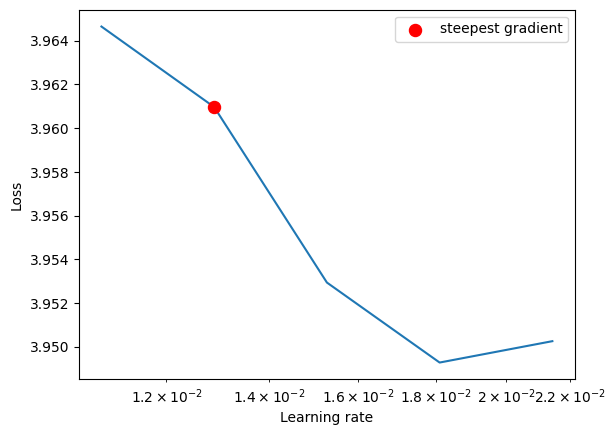

In [76]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model =  Net().to(device)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader,start_lr = 0.002, end_lr=0.05, num_iter=20)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()